In [1]:
import pickle

import os 
import glob
import random
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import plyfile

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import numpy as np

import os.path as osp
import sys
ws_dir = '/local/home/ekoller/BT'
print(ws_dir)
sys.path.append(ws_dir)
from utils import evaluation

data_dir ='/local/home/ekoller/R3Scan'
scenes_dir = '/local/home/ekoller/R3Scan/scenes'
#scan_id= "38770c95-86d7-27b8-8717-3485b411ddc7" #is reference scan  since it is a reference scan everything shouls be correctly hit
curr_scan_id = "02b33e01-be2b-2d54-93fb-4145a709cec5" 
new_scan_id =  "fcf66d8a-622d-291c-8429-0e1109c6bb26"
frame_number = "000007"
curr_frame_number = "000007"
new_frame_number = "000007"
patch_h= 18
image_height = 540
image_width = 960
patch_w = 32
patch_height = 30
patch_width = 30

/local/home/ekoller/BT
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


given the following: inout image segmented into masks and boundingboxes based on sam, the scenes of the current scan 
the features per box get compared and assigned to the most matching box.
there is also a threshold involved

In [2]:
#cosine similarity between 2 vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    return dot_product / (norm_vector1 * norm_vector2)


#iterate over everything and give back the closest match for every box in sam
def of_all_find_closes_pairs(sg_dict, img_dict):
    closest_pairs = {}
    print("sg_data object ids of image", sg_dict.keys())
    print("img_data object ids of image", img_dict.keys())

    # print("input data sg dict", sg_dict)
    # print("input data img dict", img_dict)
    #go over the image dict since we want to get the closest match of all the ids
    for img_id, img_vec in img_dict.items():
        min_distance = -1
        closest_id = None
    
        
        # go over every vector in the scenegraph
        for obj_id, obj_vec in sg_dict.items():
        
            #print("obj id vec shape", obj_vec.shape)
            #print("img id vec shape", img_vec.shape)
            cosine_similarity_all_patches = [cosine_similarity(obj_vec[i], img_vec[i]) for i in range(img_vec.shape[0])]
            average_cosine_similarity = np.mean(cosine_similarity_all_patches)
          
            
            #update
            if average_cosine_similarity> min_distance:
                min_distance = average_cosine_similarity
                closest_id= obj_id
        #check if it is close enoug using a threshold
        if min_distance > 0:
            closest_pairs[img_id] = (closest_id, min_distance)
        else:
            closest_pairs[img_id] = (0, -1)

        #closest_pairs[img_id] = (closest_id, min_distance)

    return closest_pairs
    


In [3]:
#visualitation of the following: with the new ids fill in an image with the new ids
#compute the resulting image when comparing stuff

def generate_pairs_pixel_level( dino_data,id_matches):
    
    new_ids = np.zeros((image_height, image_width))


    #go over every mask and fill in the id into the new_ids which it got mapped to
    for seg_region in dino_data:
        mask_id = seg_region["object_id"]
        #get to what the region mapped in the embeddings
        matched_id = id_matches[mask_id]
        mask = seg_region["mask"]
        new_ids[mask] = matched_id[0] #[0] is the id the second one is the error

    #returns the new ids on a pixel wise level
    return new_ids


In [4]:
#this codesegment takes an image on a pixel wise level and quantizes it such that every patch has only the id of the most often occuring id
def quantize_to_patch_level(pixelwise_img):
    #get the shape of the pixelwise img
    input_h, input_w = pixelwise_img.shape
    patch_width = int(input_w/patch_w)
    patch_height= int(input_h/patch_h)

    patchwise_w = patch_w #number of patches
    patchwise_h = patch_h

    patchwise_id = np.zeros((patchwise_h,patchwise_w))

    for i in range(patchwise_h):
            for j in range(patchwise_w):
                # Define the coordinates of the current patch
                h_start = i * patch_height
                w_start = j * patch_width
                h_end = h_start + patch_height
                w_end = w_start + patch_width
                
                # Get the current patch from the input matrix
                patch = pixelwise_img[h_start:h_end, w_start:w_end]
                
                # get the most reoccuring id of the patch
                flattened_patch = patch.flatten()
                # Find the most common value in the patch
                value_counts = Counter(flattened_patch)
                most_common_id = value_counts.most_common(1)[0][0]
                
                # Assign the most common ID to the new matrix
                patchwise_id[i, j] = most_common_id


    return patchwise_id


In [5]:
#for a given scene get the colours of the differnt object_ids
def get_id_colours(data_dir,scan_id):
    #access the mesh file to get the colour of the ids
    mesh_file = osp.join(data_dir,"scenes", scan_id, "labels.instances.annotated.v2.ply")
    ply_data = plyfile.PlyData.read(mesh_file)
    # Extract vertex data
    vertices = ply_data['vertex']
    vertex_count = len(vertices)
    
    # Initialize dictionary to store object_id -> color mappings
    object_colors = {}
    
   # Iterate through vertices
    for i in range(vertex_count):
        vertex = vertices[i]
        object_id = vertex['objectId']
        color = (vertex['red'], vertex['green'], vertex['blue'])
        
        # Check if object_id already in dictionary, otherwise initialize a Counter
        if object_id in object_colors:
            object_colors[object_id][color] += 1
        else:
            object_colors[object_id] = Counter({color: 1})
    
    # Convert Counter to dictionary with most frequent color
    for object_id, color_counter in object_colors.items():
        most_common_color = color_counter.most_common(1)[0][0]
        object_colors[object_id] = np.array(most_common_color[::-1])
    
    return object_colors

colors = get_id_colours(data_dir,curr_scan_id)
print("cur scan id colors", colors.keys())
colors = get_id_colours(data_dir,new_scan_id)
print("new scan id colors", len(colors.keys()))


cur scan id colors dict_keys([4, 18, 2, 0, 3, 1, 100, 16, 8, 9, 24, 25, 29, 6, 26, 10, 11, 23, 27, 22, 5, 20, 12, 15, 13, 14, 103, 21])
new scan id colors 15


In [6]:
#this function creates a color image of the size 960x540 from the patches
def create_color_img_from_obj_id(data_dir,scan_id,obj_id_mat):
    #access the mesh file to get the colour of the ids
    colour_dict = get_id_colours(data_dir, scan_id)
    #initialize the new matrix 
    og_height, og_width = obj_id_mat.shape
    new_height = og_height * patch_height
    new_width = og_width * patch_width

    colour_mat = np.zeros((new_height,new_width,3))

    #go over each element and assign the colour of the dictionary
    for h in range(og_height):
        for w in range(og_width):
            if obj_id_mat[h][w] in colour_dict.keys():
                colour = colour_dict[obj_id_mat[h][w]]
                colour_mat[h*patch_height:(h+1)*patch_height, w*patch_width:(w+1)*patch_width] = colour


    return colour_mat


    

In [7]:
#given a gt patchwise matrix and a newly calculated matrix compute the accuracy
#aaparently this is not the same as accuracy
def get_accuracy(gt_patches, computed_patches):
    #make sure we dont do something dumm lol
    assert gt_patches.shape == computed_patches.shape, "Matrices must have the same shape"

    # Flatten matrices to iterate over each element
    flat_gt = gt_patches.flatten()
    flat_comp = computed_patches.flatten()

    percentage = np.zeros_like(flat_gt)
    
    total_instances = len(flat_gt)
    correct_instances = 0

    #compute based on the other way
    for idx in range(len(percentage)):
        if flat_gt[idx] == flat_comp[idx]:
            percentage[idx] = 1
    
    # Count correct instances where IDs match
    for id_gt, id_comp in zip(flat_gt, flat_comp):
        if id_gt == id_comp:
            correct_instances += 1
            
    
    # Compute accuracy
    accuracy = correct_instances / total_instances
    
    return accuracy, np.mean(percentage)

In [8]:

#given a gt patchwise matrix and a newly calculated matrix compute the accuracy
def get_accuracy(gt_patches, computed_patches):
    #make sure we dont do something dumm lol
    assert gt_patches.shape == computed_patches.shape, "Matrices must have the same shape"

    # Flatten matrices to iterate over each element
    flat_gt = gt_patches.flatten()
    flat_comp = computed_patches.flatten()

    percentage = np.zeros_like(flat_gt)
    
    total_instances = len(flat_gt)
    correct_instances = 0

    #compute based on the other way
    for idx in range(len(percentage)):
        if flat_gt[idx] == flat_comp[idx]:
            percentage[idx] = 1
    
    # Count correct instances where IDs match
    for id_gt, id_comp in zip(flat_gt, flat_comp):
        if id_gt == id_comp:
            correct_instances += 1
            
    
    # Compute accuracy
    accuracy = correct_instances / total_instances
    
    return accuracy, np.mean(percentage)

new_scan_id = curr_scan_id

"""
initialize here current = new scan id since we are looking at the gt
"""

#get the Dinov2 features for the input image ( the segmented one)
input_featues_path = osp.join(data_dir,"files/Features2D/dino_segmentation/DinoV2/patch_32_18", new_scan_id + ".pkl")
with open(input_featues_path, 'rb') as file:
    input_features = pickle.load(file)

#get the data information on the segmentation of the input image
input_info_path = osp.join(data_dir,"files/Segmentation/DinoV2/objects", new_scan_id + ".pkl")
with open(input_info_path, 'rb') as file:
    input_info = pickle.load(file)

#get the computed Dinov2 featrues of the current scan
curr_featues_path = osp.join(data_dir,"files/Features2D/projection/DinoV2/patch_32_18", curr_scan_id + ".pkl")
with open(curr_featues_path, 'rb') as file:
    curr_features = pickle.load(file)

"""
compute the best match for each input on a patchwise level
"""
#closest pairs  fucking important lol !!!!!!!
id_matches = of_all_find_closes_pairs(curr_features[frame_number], input_features[new_frame_number])
print("id mateches", id_matches)

#assign each pixel to the new value, curr_scan_id , frame number is only for the size
new_img_pixelwise = generate_pairs_pixel_level(input_info[frame_number], id_matches)

#quantize to patches
new_img_patchwise = quantize_to_patch_level(new_img_pixelwise)
#aggregate to patches and colour it, we want the colours which are used in curr_scan id
new_img_colour = create_color_img_from_obj_id(data_dir,curr_scan_id, new_img_patchwise)

#get the gt input patches and also turn them into bigger images
gt_input_patchwise_path =  osp.join(data_dir,"files/patch_anno/patch_anno_32_18", new_scan_id + '.pkl')
with open(gt_input_patchwise_path, 'rb') as file:
    gt_input_patchwise = pickle.load(file)
gt_input_colour = create_color_img_from_obj_id(data_dir,curr_scan_id,gt_input_patchwise[frame_number])


accuracy = get_accuracy(gt_input_patchwise[frame_number],new_img_patchwise)
print("the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is", accuracy)


"""
display the newly computed images next to each other
"""

#display the gt_image and the new patchwise image next to each other
title1 = "gt_patces"
title2 = "dino_seg_patches"

# Create a blank canvas to combine images horizontally
height = max(gt_input_colour.shape[0], new_img_colour.shape[0])  # Max height of both images
width = gt_input_colour.shape[1] + new_img_colour.shape[1] + 20  # Total width of both images with a small gap
combined_image = np.zeros((height, width, 3), dtype=np.uint8)

# Place images with titles on the blank canvas
combined_image[:gt_input_colour.shape[0], :gt_input_colour.shape[1]] = gt_input_colour
combined_image[:new_img_colour.shape[0], gt_input_colour.shape[1] + 20:] = new_img_colour

# Add titles to the images
cv2.putText(combined_image, title1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(combined_image, title2, (gt_input_colour.shape[1] + 30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

# Display the combined image
cv2.imshow('Two Images Side by Side', combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


"""
find changes beginning: based on projection onto current mesh
"""

#compute the projection of the new pose onto the current mesh to get the current situation

curr_proj_obj_id, curr_proj_color = evaluation.project_new_pose_in_curr_mesh(data_dir, osp.join(data_dir, "scenes"),curr_scan_id, new_scan_id, frame_number)
cv2.imshow("object_id", curr_proj_obj_id)
cv2.imshow("color", curr_proj_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

#quantize that projection such that it is on patchwise level
#actually with this we can compute the current change
curr_proj_obj_patchwise = quantize_to_patch_level(curr_proj_obj_id)











sg_data object ids of image dict_keys([0, 1, 4, 13, 14, 15, 18])
img_data object ids of image dict_keys([1, 2, 3, 4, 5, 6, 7])
id mateches {1: (1, 0.23899677), 2: (1, 0.08142349), 3: (1, 0.1922251), 4: (13, 0.13733645), 5: (4, 0.24514586), 6: (15, 0.17942092), 7: (4, 0.1467393)}
the accuracy for the current features of the sam boundingboxes vs the gt boundingboxes is (0.001736111111111111, 0.001736111111111111)


here is the segment to check if the boundingboxes/ data given to sam is actually correct also visualizes them

the next segment tries to estimate the folowing: given a feature vector of the sg_graph and take the mean of each object -> so the current mesh -> and the groundtruthboundingboxes look how close the features are

prints out the content to know what we are dealing with

In [ ]:
# Inspect the loaded data
def inspect_data(data, indent=0):
    space = " " * indent
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"{space}{key}:")
            inspect_data(value, indent + 2)
    elif isinstance(data, list):
        print(f"{space}List with {len(data)} elements")
        if len(data) > 0 and not isinstance(data[0], (dict, list)):
            print(f"{space}{data[:3]}...")  # Show only the first 3 elements
        else:
            for i, item in enumerate(data):
                print(f"{space}[{i}]")
                inspect_data(item, indent + 2)
    else:
        print(f"{space}{data}")


#get the data information on the segmentation of the input image
input_info_path = osp.join(data_dir,"files/Segmentation/DinoV2/objects", new_scan_id + ".pkl")
with open(input_info_path, 'rb') as file:
    input_info = pickle.load(file)
    
#inspect_data(input_info)



#get the Dinov2 features for the input image ( the segmented one)
input_featues_path = osp.join(data_dir,"files/Features2D/dino_segmentation/DinoV2/patch_32_18", new_scan_id + ".pkl")
with open(input_featues_path, 'rb') as file:
    input_features = pickle.load(file)

#inspect_data(input_features)
    

    

this segment looks what we are computing the features of

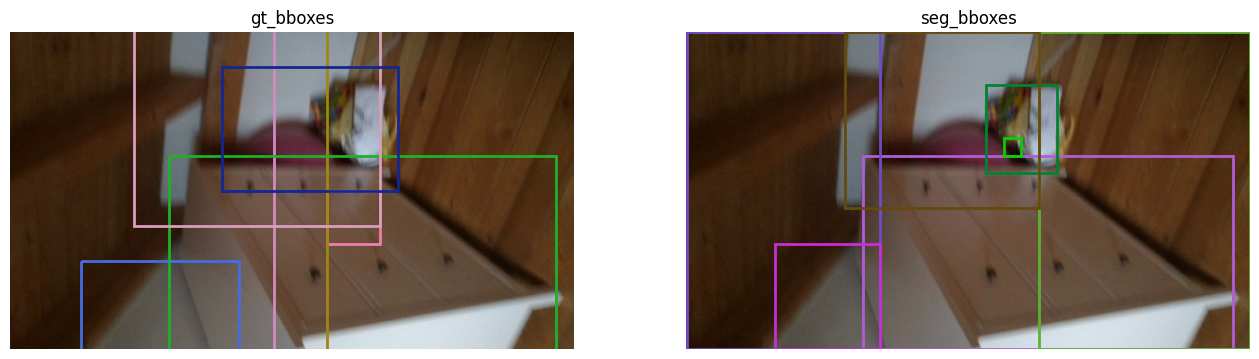

In [9]:
def bounding_boxes_for_projection(data_dir, scan_id, frame_number):
    #access the projection

    proj_rgb= osp.join(data_dir, "files/gt_projection", "obj_id", scan_id,"frame-" + frame_number +".jpg")
    #print("proj file", proj_rgb)
    obj_mat = cv2.imread(proj_rgb, cv2.IMREAD_UNCHANGED)
    img_height, img_width= obj_mat.shape
    new_id = np.zeros_like(obj_mat)
    patch_width = int(img_width/patch_w)
    patch_height = int(img_height/patch_h)
    
    for h in range(0, img_height, patch_height):
        for w in range(0, img_width, patch_width):
            patch = obj_mat[h:h+patch_height, w:w+patch_width]
            # flatten the array to 1d
            flattened_patch = patch.flatten()
            # Find the most common value
            value_counts = Counter(flattened_patch)
            most_common_value = value_counts.most_common(1)[0][0]
            # Fill the patch with the most common color
            new_id[h:h+patch_height, w:w+patch_width] = most_common_value


    #compute the boundingboxes based on that new obj_id_mask
    bounding_boxes = []
    unique_ids = np.unique(new_id)

    #make the boundingboxes for the ids which got recognized
    for obj_id in unique_ids:
        # Create mask for current object ID
        mask = (new_id == obj_id)

        # Find bounding box coordinates
        rows, cols = np.nonzero(mask)
        if len(rows) > 0 and len(cols) > 0:
            min_row, max_row = np.min(rows) - (patch_height), np.max(rows) + (patch_height)
            min_col, max_col = np.min(cols) - (patch_width), np.max(cols) + (patch_width)

            # Calculate height and width
            height = max_row - min_row + 1
            width = max_col - min_col +1

            # Store bounding box information
            bounding_boxes.append({
                'object_id': obj_id,
                'bbox': [min_col, min_row, width, height]
            })

    return bounding_boxes













#sanity check that the sam boundingboxes are not very wrong
IMAGE_PATH= osp.join(data_dir,"scenes",curr_scan_id,"sequence","frame-"+str(frame_number)+".color.jpg")
# Read the image from the path
image= cv2.imread(IMAGE_PATH)

#get the data information on the segmentation of the input image
dino_seg_path = osp.join(data_dir,"files/Segmentation/DinoV2/objects", new_scan_id + ".pkl")
with open(dino_seg_path, 'rb') as file:
    seg_data= pickle.load(file)

#curretnly take the same image 2 times
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 

#sam boxes
for segment in seg_data[frame_number]:
    #access the boundingbox
    x_min, y_min, width, height = segment["bbox"]
    color =  tuple(random.random() for _ in range(3))
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
    # Add the patch to the Axes
    ax2.add_patch(rect)

#gt boxes
gt_bboxes = bounding_boxes_for_projection(data_dir, curr_scan_id, frame_number)
for box in gt_bboxes:
    x_min, y_min, width, height = box["bbox"]
    color =  tuple(random.random() for _ in range(3))
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)

#add name
ax2.set_title('seg_bboxes')
ax1.set_title('gt_bboxes')
# Remove axis labels for both subplots
ax1.axis('off')
ax2.axis('off')
plt.show()